In [15]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras.layers
from tensorflow.keras.models import Model
from keras.optimizers import SGD
import tensorflow as tf  
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import efficientnet
import keras.preprocessing.image

In [2]:
#Load all data within folders in Train and Test 
trainingData = glob.glob("/common/cse479/mpham9/Train/*/*")
testingData = glob.glob("/common/cse479/mpham9/Test/*/*")

# Setting batch size and image size
imageWidth, imageHeight = 224, 224
batchSize = 32 ##

In [3]:
# random data augmentation
trainDataAug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 30,
    rescale=1/200,
    height_shift_range=0.1,
    width_shift_range=0.1,
    shear_range=.1,
    zoom_range=0.2,
    horizontal_flip=True)

#Rescale training data
valDataAug = keras.preprocessing.image.ImageDataGenerator(rescale=1/200)

In [4]:
# getting the path to the data
trainDataPath = "/common/cse479/mpham9/Train"
testDataPath = "/common/cse479/mpham9/Test/"

In [5]:
# converting data to a tensorflow data
trainGenerator = trainDataAug.flow_from_directory(
    trainDataPath,
    target_size=(224, 224),
    batch_size=batchSize,
    class_mode='categorical')

validationGenerator = valDataAug.flow_from_directory(
    testDataPath,
    target_size=(224, 224),
    batch_size=batchSize,
    class_mode='categorical')

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [6]:
# loading the EfficientNetB1 model
efficientnetModel = efficientnet.EfficientNetB1(weights='imagenet', include_top=False)

# adding some extra layers
x = efficientnetModel.output
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
predictions = tensorflow.keras.layers.Dense(196, activation='softmax')(x)
model = Model(inputs=efficientnetModel.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in efficientnetModel.layers:
    if isinstance(layer, tensorflow.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

# Check If Layers are Set Correctly
#for i, layer in enumerate(efficientnetModel.layers):
  #  print(i, layer.name, layer.trainable)

## compiles model with optimizer 
model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy']) #LR .0005 next



2023-08-07 17:04:27.182427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
## train the model
results = model.fit_generator(generator=trainGenerator,
                    steps_per_epoch=len(trainGenerator),
                    validation_data=validationGenerator,
                    validation_steps=len(validationGenerator),
                    epochs=30)

/tmp/ipykernel_1773892/1694937090.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(generator=trainGenerator,


Epoch 1/30
127/127 [==============================] - 231s 2s/step - loss: 5.2188 - accuracy: 0.0249 - val_loss: 5.3716 - val_accuracy: 0.0037
Epoch 2/30
127/127 [==============================] - 225s 2s/step - loss: 4.5525 - accuracy: 0.1179 - val_loss: 5.4356 - val_accuracy: 0.0067
Epoch 3/30
127/127 [==============================] - 222s 2s/step - loss: 3.8928 - accuracy: 0.2120 - val_loss: 5.1882 - val_accuracy: 0.0233
Epoch 4/30
127/127 [==============================] - 225s 2s/step - loss: 3.2360 - accuracy: 0.3056 - val_loss: 4.5640 - val_accuracy: 0.0868
Epoch 5/30
127/127 [==============================] - 222s 2s/step - loss: 2.7836 - accuracy: 0.3868 - val_loss: 3.4464 - val_accuracy: 0.2329
Epoch 6/30
127/127 [==============================] - 227s 2s/step - loss: 2.3642 - accuracy: 0.4739 - val_loss: 2.7288 - val_accuracy: 0.3609
Epoch 7/30
127/127 [==============================] - 224s 2s/step - loss: 2.0019 - accuracy: 0.5310 - val_loss: 2.3884 - val_accuracy: 0.4355

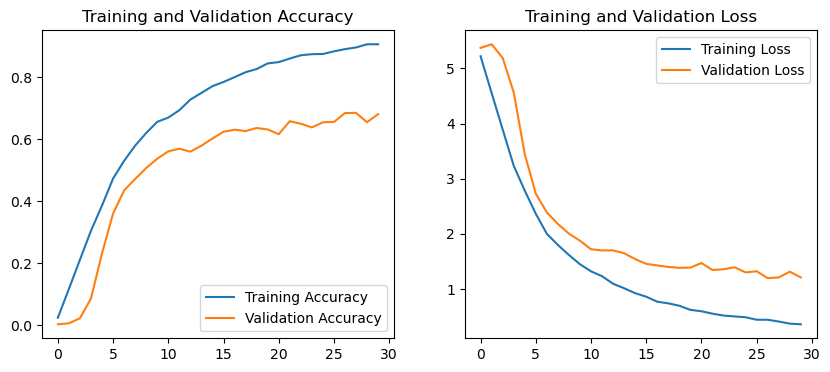

In [8]:
accuracy = results.history['accuracy']
valAccuracy2 = results.history['val_accuracy']
loss = results.history['loss']
valLoss = results.history['val_loss']
epochsNum = range(30)

# plot loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochsNum, accuracy, label='Training Accuracy')
plt.plot(epochsNum, valAccuracy2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochsNum, loss, label='Training Loss')
plt.plot(epochsNum, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()